In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
from statsmodels.stats.power import NormalIndPower

In [139]:
df = pd.read_csv("C:/Users/afari/Desktop/desktop/upskilling 2025/abtesting data/binomial_test_data.csv")

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294404 entries, 0 to 294403
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294404 non-null  int64 
 1   group         294404 non-null  object
 2   landing_page  294404 non-null  object
 3   converted     294404 non-null  int64 
 4   country       294404 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


READ ME
Desiging an a/b experiment. In this project we are working retrospetively with data that has already been collected. In the event we needed to design the test from scratch we would need to calculate the optimal sample size which reduces the instances of statistical errors. To find the sample size we would go through the steps below. 

MDE - Minimum detectable effort; it is a numeric value to represent the smallest amount of change we would call significant between the control and treatment groups. It is usually set by stakeholders based on historic performance

Calculate p1 = proportion of successes / total number of events 
Calculate p2 = p1 + MDE

Effort Size: Calculate with Cohens H
Alpha value: 0.05
Power Threshold(1 - Beta): 80%

#### Calculating proprtions of conversions within each group

In [104]:
# counting the number of people who converted from the control 
convert_control = df.groupby('group')['converted'].sum().loc['control']
print("Total coverted from control is:", convert_control)
# counting the number of people who converted from the experiment 
convert_treatment = df.groupby('group')['converted'].sum().loc['treatment']
print("Total coverted from treatment is:", convert_treatment)

Total coverted from control is: 60804
Total coverted from treatment is: 17506


In [105]:
# count the total number of people in the control group
control_total = df['group'].value_counts().loc['control']
print("Total number of control is:", control_total)
# count the total number of people in the treatment group
treatment_total = df['group'].value_counts().loc['treatment']
print("Total number of treatment is:", treatment_total)

Total number of control is: 147202
Total number of treatment is: 147202


In [106]:
# calculate the proportion of people in the control group that converted 
prop_control_convert = convert_control/control_total
print("Total proportion of control is:", prop_control_convert)
# calculate the proportion of people in the treatment group that converted 
mde = 0.05
prop_treatment_convert = prop_control_convert + mde
print("Total proportion of treaatment is:", prop_treatment_convert)


Total proportion of control is: 0.4130650398771756
Total proportion of treaatment is: 0.46306503987717557


#### Calculating effect size (ie, the magnitude of the difference between the 2 groups)

In [107]:
# calculate cohens h
def cohens_h(control, treatment):
    return 2 * (np.arcsin(np.sqrt(treatment))) - 2*(np.arcsin(np.sqrt(control)))

In [108]:
effect_size = cohens_h(prop_control_convert, prop_treatment_convert)
print("Cohen's h:", effect_size)

Cohen's h: 0.10082082543466142


#### Calculating the sample size

In [109]:
# Calculate optiml sample size with power
alpha = 0.05
power = 0.8
effect_size = effect_size

In [110]:
# Create an instance of NormalIndPower
power_analysis = NormalIndPower()

In [111]:
# Calculate smple size
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha,  ratio=1)
print(f"Sample size needed per group: {sample_size:.0f}")

Sample size needed per group: 1544


### Exploratory Data Analysis

In [112]:
# Check columns in the dataframe
print(df.columns)

Index(['user_id', 'group', 'landing_page', 'converted', 'country'], dtype='object')


In [113]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294404 entries, 0 to 294403
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294404 non-null  int64 
 1   group         294404 non-null  object
 2   landing_page  294404 non-null  object
 3   converted     294404 non-null  int64 
 4   country       294404 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


In [114]:
# Check for nulls
print(df.isnull().sum())

user_id         0
group           0
landing_page    0
converted       0
country         0
dtype: int64


In [115]:
# Check the balance between control and treatment groups
print(df['group'].value_counts())

group
control      147202
treatment    147202
Name: count, dtype: int64


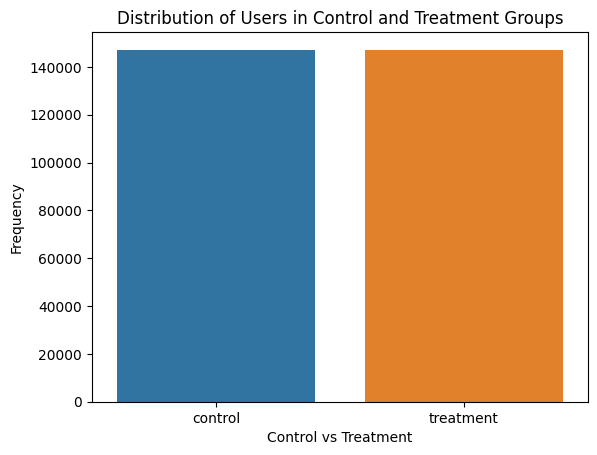

In [116]:
# Visualise groups with a histogram
sns.countplot(x='group', hue='group', data=df)
plt.xlabel('Control vs Treatment')
plt.ylabel('Frequency')
plt.title("Distribution of Users in Control and Treatment Groups")
plt.show()

Takeaways:The dataset has no nulls and the total number of the control group is very close to the treatment group

#### Analyze the Target Variable (converted)

In [117]:
# Calculate the total proportion of users who converted.
overall_conversion_rate = df['converted'].mean()
print("Overall conversion rate:", overall_conversion_rate)

Overall conversion rate: 0.2659950272414777


In [118]:
# Calculate the proportion of users who converted by group.
conversion_rates = df.groupby('group')['converted'].mean()
print("Conversion rates by group:\n", conversion_rates)

Conversion rates by group:
 group
control      0.413065
treatment    0.118925
Name: converted, dtype: float64


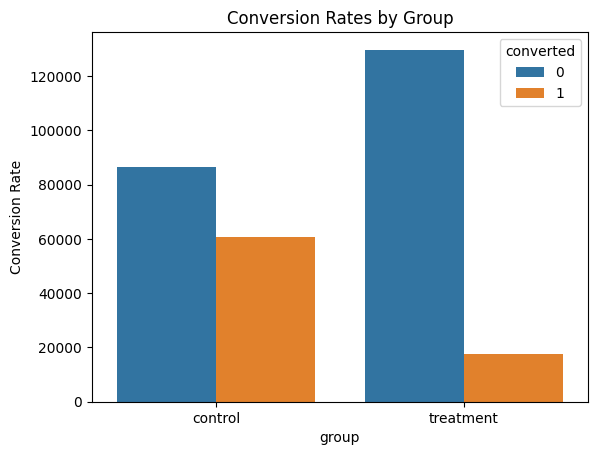

In [119]:
# Visualize conversion rates by group:
sns.countplot(x='group', hue='converted', data=df)
plt.title('Conversion Rates by Group')
plt.ylabel('Conversion Rate')
plt.show()

In [120]:
# Calculate the number of users who converted by country.
conversion_rates = df.groupby('country')['converted'].mean()
print("Conversion rates by county:\n", conversion_rates)

Conversion rates by county:
 country
CA    0.262047
UK    0.265576
US    0.266425
Name: converted, dtype: float64


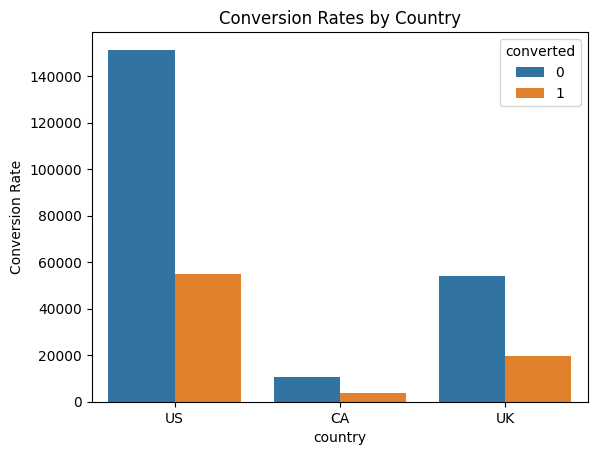

In [121]:
# Visualize conversion rates by country:
sns.countplot(x='country', hue='converted', data=df)
plt.title('Conversion Rates by Country')
plt.ylabel('Conversion Rate')
plt.show()

Takeaways Overall around 26% of total customers converted. Looking at the 26% as a total of 100% for conversions, around 41% of conversions came from the control group and 11% from the treatement group. Assesing by country the US had the highest number of customers and the highest conversions and Canada had the least number of customers with the lowest conversions

### Hypothesis Testing - Z-scores for proportions

We want to determine if the difference between the converted and non converted is just due to chance or has some statistical significance.

Hypothesis
Null Hypothesis (H0): The new landing page does not affect customer conversion rates (i.e., conversion rates for the old and new pages are the same).
Alternative Hypothesis (H1): The new landing page affects customer conversion rates (i.e., the conversion rates for the old and new pages are different).
In this case since the hypothesis doesnt explicitly say greater than or less than we will use the two tailed test

In [122]:
# Refresher on converted vs non converted values and thier probabilities 
converted_non_converted_group = pd.pivot_table (df, index=['group'], columns=['converted'], aggfunc='size')
print(f'Grouped table for conversions: \n {converted_non_converted_group}')

Grouped table for conversions: 
 converted       0      1
group                   
control     86398  60804
treatment  129696  17506


In [123]:
# calculate the proportion of people in the control group that converted 
p_hat_control = convert_control/control_total
print("Total proportion of converted from control is:", p_hat_control)

p_hat_treatment = convert_treatment/treatment_total
print("Total proportion of treatment is:", p_hat_treatment)

Total proportion of converted from control is: 0.4130650398771756
Total proportion of treatment is: 0.11892501460577981


In [124]:
pooled_phats = (convert_control+convert_treatment)/(control_total + treatment_total)
print(f'Pooled phats is:\n',{pooled_phats})

Pooled phats is:
 {np.float64(0.2659950272414777)}


In [125]:
standard_error = np.sqrt(pooled_phats*(1-pooled_phats)*((1/control_total)+(1/treatment_total)))
print(f'Standard error is:\n',{standard_error})

Standard error is:
 {np.float64(0.0016287123982955084)}


Calculate zscore for proportions

In [126]:
z_score = (p_hat_control - p_hat_treatment) / standard_error
print(f'Z score is:\n',{z_score})

Z score is:
 {np.float64(180.59666370761423)}


Calculate pvalue

In [127]:
p_value_two_tailed = 2 * (1 - norm.cdf(abs(z_score)))
print(f"Two-Tailed p-Value: {p_value_two_tailed:.4f}")

Two-Tailed p-Value: 0.0000


The calculated p-value is less than the set alpha of 0.05 so we reject the null hypothesis that The new landing page does not affect customer conversion rates

### Hypothesis Testing - CHI Square Goodness of fit 

In [128]:
# Conversion rate old webpage
Conversion_old_page_rate = (convert_control/control_total)
print(f"Conversion rate for old page is: {Conversion_old_page_rate:.3f}")

Conversion rate for old page is: 0.413


In [129]:
# Expected number to convert under from old webpage 
Conversion_old_page = Conversion_old_page_rate * control_total
print(f"Expected number to convert is: {Conversion_old_page:.0f}")

Expected number to convert is: 60804


In [130]:
print(f"Actual number of people who converted from the old webpage: {convert_control}")

Actual number of people who converted from the old webpage: 60804


In [131]:
# Expected number to convert under from new webpage if the new 
# webpage has no influence on conversions 
Conversion_new_page = Conversion_old_page_rate * treatment_total
print(f"Expected number to convert is: {Conversion_new_page:.0f}")

Expected number to convert is: 60804


In [132]:
# Actual number of people who converted from the new webpage  conversion rate
print(f"Actual number of people who converted from the new webpage: {convert_treatment}")

Actual number of people who converted from the new webpage: 17506


In [133]:
# Chi Square
contol_group = ((convert_control - Conversion_old_page)**2 )/ Conversion_old_page
print(f"{contol_group}")
treatment_group = ((convert_treatment - Conversion_new_page)**2 )/ Conversion_new_page
print(f"{treatment_group}")

0.0
30832.129530951912


In [134]:
# Sum of Chi-Square Contributions
x = contol_group + treatment_group
print(f"Sum of Chi-Square Contributions: {x}")

Sum of Chi-Square Contributions: 30832.129530951912


In [136]:
# Degrees of freedom
Number_of_groups = len(df['group'].unique())
deg_f = Number_of_groups -1
print(f"Degrees of freedom: {deg_f}") 

Degrees of freedom: 1


In [137]:
# pvalue 
p_value = 1 - chi2.cdf(x, deg_f)
print(f"P value is: {p_value}") 

P value is: 0.0


The calculated p-value is again less than the set alpha of 0.05 so we reject the null hypothesis that The new landing page does not affect customer conversion rates